In [1]:
import numpy as np
import mrcfile 
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F 
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta

from PIL import Image 
from tqdm import tqdm

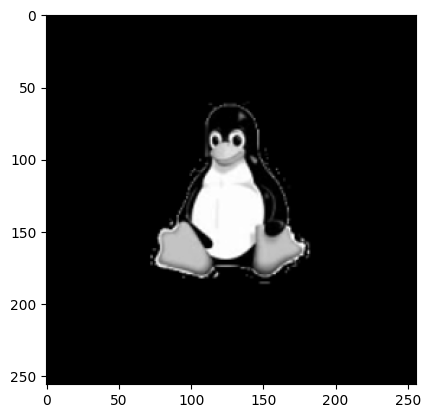

In [34]:
image = np.array(Image.open("image.png").convert('L').resize((256,256)))
plt.imshow(image,cmap='gray');

In [35]:
np.mean(image)

np.float64(16.39312744140625)

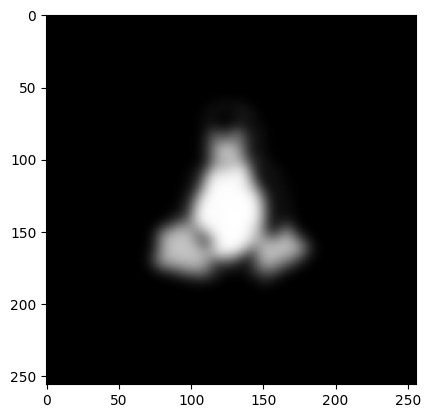

In [33]:
init = np.array(Image.open("init.png").convert('L').resize((256,256)))
plt.imshow(init,cmap='gray');

In [3]:

def generate_data(K,std=1,std_xy=5,n=256):
    img = Image.open("image.png").convert("L").resize((n,n))
    img = torch.tensor(np.array(img),dtype=torch.float32)

    #img = (img - img.min())/(img.max() - img.min())

    thetas = (2 * torch.pi) * torch.rand(size=(K,))
    normal_dist = MultivariateNormal(loc=torch.zeros(2), 
                                     covariance_matrix=std_xy * torch.eye(2))
    beta_dist = Beta(2, 5)
    translations = normal_dist.sample((K,))
    scales = 5*beta_dist.sample((K,))

    transformations = torch.zeros((K, 2, 3))
    transformations[:, 0, 0] = torch.cos(thetas)
    transformations[:, 0, 1] = -torch.sin(thetas)
    transformations[:, 1, 0] = torch.sin(thetas)
    transformations[:, 1, 1] = torch.cos(thetas)
    transformations[:, :, 2] = 2*translations/n

    grid = F.affine_grid(transformations, size=(K, 1, n, n), align_corners=False)
    data = F.grid_sample(img.expand(K, 1, n, n), grid, align_corners=False).squeeze(1)
    data = data * scales.view(K,1,1) + torch.normal(mean=0,std=std,size=(K,n,n))
    #data = data + torch.normal(mean=0,std=std,size=(K,n,n))

    return data

@torch.no_grad()
def expectation_maximization(device,A, data, std, std_xy, K=10000,N=800):
    # - Check problem with std growing
    n = A.shape[0]    
    batch_size = K // 10
    num_batch = K // batch_size

    normal_dist = MultivariateNormal(loc=torch.zeros(2).to(device), 
                                     covariance_matrix=std_xy * torch.eye(2).to(device))
    uniform_dist = Uniform(0,2*torch.pi)
    beta_dist = Beta(torch.tensor(2.0).to(device), torch.tensor(5.0).to(device))

    A_t = torch.zeros_like(A,dtype=torch.float32).to(device)
    std_t = torch.tensor(0,dtype=torch.float32).to(device)
    stdxy_t = torch.tensor(0,dtype=torch.float32).to(device)
    Z = torch.tensor(0, dtype=torch.float32).to(device)
    for i in tqdm(range(N)):
        X = data[i]

        integral = torch.zeros_like(A_t,dtype=torch.float32)
        std_batch = torch.tensor(0,dtype=torch.float32).to(device) 
        stdxy_batch = torch.tensor(0,dtype=torch.float32).to(device)
        Z_batch = torch.tensor(0, dtype=torch.float32).to(device)

        for _ in range(num_batch):
            thetas = uniform_dist.sample((batch_size,)).to(device)
            translations = normal_dist.sample((batch_size,)).to(device)
            scales = beta_dist.sample((batch_size,)).to(device)
            

            thetas_logits = uniform_dist.log_prob(thetas).to(device)
            translations_logits = normal_dist.log_prob(translations).to(device)
            #scales_logits = beta_dist.log_prob(scales/5.0).to(device) - torch.log(torch.tensor(5.0))
            scales_logits = beta_dist.log_prob(scales).to(device)

            scales = 5.0*scales

            transformations = torch.zeros((batch_size, 2, 3)).to(device)
            transformations[:, 0, 0] = torch.cos(thetas)
            transformations[:, 0, 1] = -torch.sin(thetas)
            transformations[:, 1, 0] = torch.sin(thetas)
            transformations[:, 1, 1] = torch.cos(thetas)
            transformations[:, :, 2] = 2*translations / n # PyTorch assumes translations are in [-1,1]

            grid = F.affine_grid(transformations, size=(batch_size, 1, n, n), align_corners=False)
            A_psi = F.grid_sample(A.expand(batch_size, 1, n, n), grid, align_corners=False).squeeze(1) * (scales.view(-1,1,1))

            inv_rotations = transformations[...,:2].permute(0,2,1)
            inv_t = -torch.bmm(inv_rotations,transformations[...,2:])
            inv_trans = torch.cat([inv_rotations,inv_t],dim=-1)
            inv_grid = F.affine_grid(inv_trans,size=(batch_size,1,n,n), align_corners=False) 

            X_psi = F.grid_sample(X.expand(batch_size, 1, n, n) , inv_grid, align_corners=False).squeeze(1) / scales.view(-1,1,1)

            X_log_density = -(torch.norm(X - A_psi,dim=(1,2))/255) ** 2 / (2*std ** 2)
            #X_log_density = -(torch.norm(X - A_psi,dim=(1,2))) ** 2 / (2*std ** 2)
            X_log_density = X_log_density - torch.logsumexp(X_log_density,0) # Stable normalization

            psi_log_density = thetas_logits + translations_logits + scales_logits

            transformations_error = (torch.norm(X_psi - A, dim=(1,2))/255)** 2
            #transformations_error = (torch.norm(X_psi - A, dim=(1,2)))** 2
  
            w = torch.exp(X_log_density + psi_log_density)
            w /= w.sum()

            Z_batch += (w * (scales**2)).sum()
            #std_batch += ( w.view(batch_size,1,1) * (scales**2) * (torch.norm(X_psi - A,dim=(1,2))/255) ** 2 ).sum()
            std_batch += ( w.view(batch_size,1,1)  * transformations_error).sum()
            stdxy_batch += (w.view(batch_size,1,1) * (torch.norm(translations,dim=1)**2)).sum()
            integral += (w.view(batch_size, 1, 1) * X_psi * (scales**2).view(batch_size,1,1)).sum(dim=0)
        A_t += integral/K
        std_t +=  std_batch / K
        stdxy_t +=  stdxy_batch/K   
        Z += Z_batch/K
    std_t /= (n**2)
    std_t /= data.shape[0]
    std_t = std_t ** 0.5
    stdxy_t /= 2*data.shape[0]
    stdxy_t = stdxy_t ** 0.5
    print(f"Updated noise variance estimation: {std_t}")
    print(f"Updated translations variance estimation: {stdxy_t}")
    return A_t/Z, std_t, stdxy_t

In [78]:
device = 'cuda:1'
std = torch.tensor(1).to(device)    
std_xy = torch.tensor(80).to(device)

data = generate_data(100,1,100)
data = data.to(device)

n = init.shape[0]
A = torch.tensor(init,dtype=torch.float32).to(device)
K = 10000

In [79]:
n = A.shape[0]    
batch_size = K // 10
num_batch = K // batch_size

normal_dist = MultivariateNormal(loc=torch.zeros(2).to(device), 
                                     covariance_matrix=std_xy * torch.eye(2).to(device))
uniform_dist = Uniform(0,2*torch.pi)
beta_dist = Beta(torch.tensor(2.0).to(device), torch.tensor(5.0).to(device))

A_t = torch.zeros_like(A,dtype=torch.float32).to(device)
std_t = torch.tensor(0,dtype=torch.float32).to(device)
stdxy_t = torch.tensor(0,dtype=torch.float32).to(device)
Z = torch.tensor(0, dtype=torch.float32).to(device)

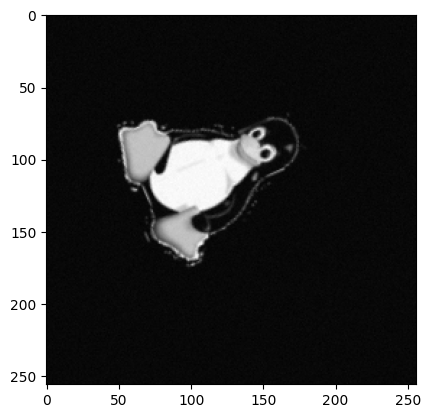

In [90]:
plt.imshow(data[80].cpu().numpy(),cmap='gray')

In [91]:
for i in range(1):
    X = data[80]
    integral = torch.zeros_like(A_t,dtype=torch.float32)
    std_batch = torch.tensor(0,dtype=torch.float32).to(device) 
    stdxy_batch = torch.tensor(0,dtype=torch.float32).to(device)
    Z_batch = torch.tensor(0, dtype=torch.float32).to(device)

    for j in range(num_batch):
        thetas = uniform_dist.sample((batch_size,)).to(device)
        translations = normal_dist.sample((batch_size,)).to(device)
        scales = beta_dist.sample((batch_size,)).to(device)

        thetas_logits = uniform_dist.log_prob(thetas).to(device)
        translations_logits = normal_dist.log_prob(translations).to(device)
        scales_logits = beta_dist.log_prob(scales/5.0).to(device) - torch.log(torch.tensor(5.0))

        scales = 5.0*scales

        transformations = torch.zeros((batch_size, 2, 3)).to(device)
        transformations[:, 0, 0] = torch.cos(thetas)
        transformations[:, 0, 1] = -torch.sin(thetas)
        transformations[:, 1, 0] = torch.sin(thetas)
        transformations[:, 1, 1] = torch.cos(thetas)
        transformations[:, :, 2] = 2*translations / n # PyTorch assumes translations are in [-1,1]

        grid = F.affine_grid(transformations, size=(batch_size, 1, n, n), align_corners=False)
        A_psi = F.grid_sample(A.expand(batch_size, 1, n, n), grid, align_corners=False).squeeze(1) * (scales.view(-1,1,1))

        inv_rotations = transformations[...,:2].permute(0,2,1)
        inv_t = -torch.bmm(inv_rotations,transformations[...,2:])
        inv_trans = torch.cat([inv_rotations,inv_t],dim=-1)
        inv_grid = F.affine_grid(inv_trans,size=(batch_size,1,n,n), align_corners=False) 

        X_psi = F.grid_sample(X.expand(batch_size, 1, n, n), inv_grid, align_corners=False).squeeze(1) / (scales.view(-1,1,1))

        X_log_density = -(torch.norm(X - A_psi,dim=(1,2))/255) ** 2 / (2*std ** 2)
        X_log_density = X_log_density - torch.logsumexp(X_log_density,0) # Stable normalization

        psi_log_density = thetas_logits + translations_logits + scales_logits
  
        w = torch.exp(X_log_density + psi_log_density)
        w /= w.sum()
        Z_batch += (w * scales**2).sum()
        std_batch += ( w.view(batch_size,1,1) *(torch.norm(X - A_psi,dim=(1,2))/255) ** 2 ).sum()
        stdxy_batch += (w.view(batch_size,1,1) * (torch.norm(translations,dim=1)**2)).sum()
        integral += (w.view(batch_size, 1, 1) * X_psi * (scales**2).view(batch_size,1,1)).sum(dim=0)

    A_t += integral/K
    std_t +=  std_batch / K
    stdxy_t +=  stdxy_batch/K   
    Z += Z_batch/K
std_t /= (n**2)
std_t /= data.shape[0]
std_t = std_t ** 0.5
stdxy_t /= 2*data.shape[0]
stdxy_t = stdxy_t ** 0.5

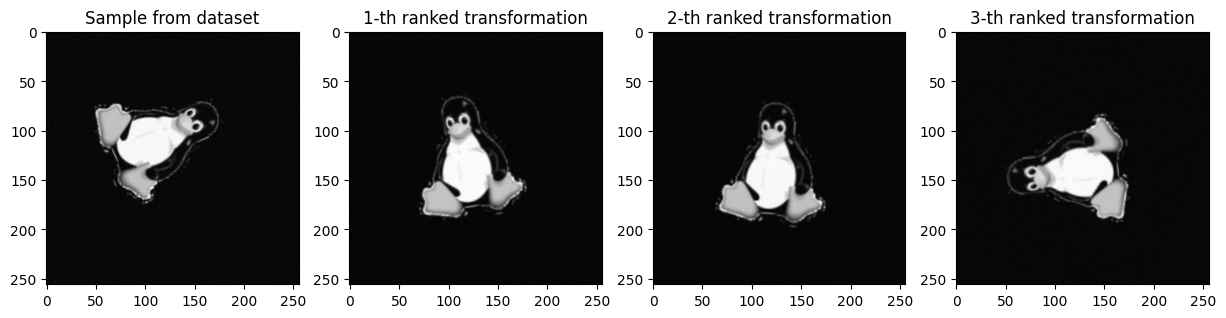

In [92]:
fig, ax = plt.subplots(1,4,figsize=(15,5))

_,indices = torch.topk(w, 3)
ax[0].imshow(X.cpu().numpy(),cmap='gray')
ax[0].set_title("Sample from dataset")

for i in range(0,3):
    ax[i+1].imshow(X_psi[indices[i].item()].cpu().numpy(),cmap='gray')
    ax[i+1].set_title(f"{i+1}-th ranked transformation")

In [96]:
w.unique()

tensor([0.0000e+00, 1.0477e-39, 1.5855e-33, 1.5782e-30, 7.6070e-26, 1.8804e-04,
        9.9981e-01], device='cuda:1')

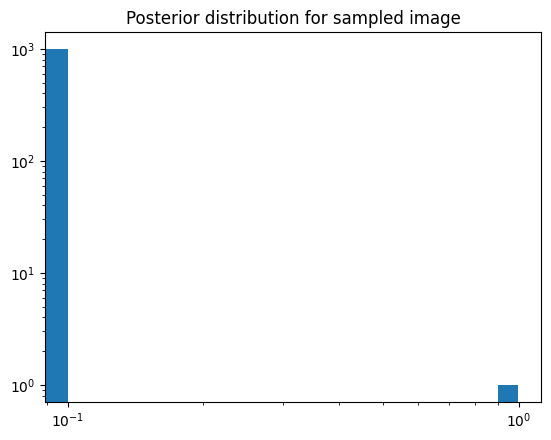

In [ ]:
plt.hist(w.cpu().numpy()    )
plt.title("Posterior distribution for sampled image")
plt.yscale('log')
plt.xscale('log')